<a href="https://colab.research.google.com/github/panghanwu/tibame_project/blob/main/neo4j_import_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script includes uploading csv data to Neo4j and query algorithm.

In [1]:
!pip install py2neo
import py2neo as neo
import pandas as pd
import random

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 348kB 8.7MB/s 
     |████████████████████████████████| 153kB 7.5MB/s 
     |████████████████████████████████| 2.6MB 12.9MB/s 
     |████████████████████████████████| 204kB 32.1MB/s 
  Created wheel for neotime: filename=neotime-1.7.4-cp36-none-any.whl size=20543 sha256=2169cef1a40a9c12827db1743dba865b6cc5bfdeebdc0cc18a1171d976b22c7a
  Stored in directory: /root/.cache/pip/wheels/d4/b4/c4/ab867cd0ac9e667f8cd269f9364fd1cb8ee75fe50f5ce97c79
Successfully built neotime
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 2.0.10 which is incompatible.
ERROR: ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.10 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [2]:
"""load data"""
# login info
info = pd.read_csv('login_info.csv', header=None)
sever_link = info[0][0]
pws = info[1][0]

# product info
product_df = pd.read_csv('product_node.csv')
# relation matrix
relation_df = pd.read_csv('relationship_matrix.csv', index_col=0)

"""Relation matrix preprocessing""" 
# fill None with .0
relation_df = relation_df.fillna(0.0)

psn = relation_df.index  # data list
pn = len(psn)  # data size

# add little fluctuation
def fluctuate(d):
  if d == 2.0 or d == 0.0:
    return d
  else:
    r = round(random.uniform(-0.05,0.05), 3)
    return d + r

# def fluctuate(d):
#   if d == 0:
#     return d + 1

for i in range(pn):
  relation_df[psn[i]] = relation_df[psn[i]].apply(fluctuate)

# diagonal symmetry
relation_df = relation_df + relation_df.T

product_df

,sn,name,image_url,description
0,MU01,雙面可穿鋪棉連帽大衣,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,男裝雙面可穿鋪棉連帽大衣NT 軍綠
1,MU02,雙面可穿鋪棉連帽大衣,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,男裝雙面可穿鋪棉連帽大衣NT 米白
2,MU03,棒球外套,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,男裝棒球外套STUDIO SEVEN 灰色
3,MU04,棒球外套,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,男裝棒球外套STUDIO SEVEN 黑色
4,MU05,寬版鋪綿牛仔外套,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,男裝寬版鋪綿牛仔外套
...,...,...,...,...
97,FU14,多層次穿搭針織衫,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,女裝多層次穿搭針織衫(附背心兩件組)(長袖) 看起來像層搭圓弧衣襬襯衫的假兩件針織衫。在好搭...
98,FU15,羅紋中高領針織衫,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,女裝羅紋中高領針織衫(長袖) 採用具時尚感的中高領設計，展現俐落感的羅紋針織衫。使用不易起毛...
99,FU16,羅紋中高領針織衫,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,女裝羅紋中高領針織衫(長袖) 採用具時尚感的中高領設計，展現俐落感的羅紋針織衫。使用不易起毛...
100,FU17,Soft RichV領針織長上衣,https://im.uniqlo.com/images/tw/gu/pc/goods/32...,女裝Soft RichV領針織長上衣(長袖) 可露出美麗肩頸的V領針織長上衣。特色是蓬鬆柔軟...


In [3]:
relation_df

,MU01,MU02,MU03,MU04,MU05,MU06,MU07,MU08,MU09,MU10,MU11,MU12,MU13,MU14,MU15,MU16,MU17,MU18,MU19,MU20,MU21,MU22,MU23,MU24,MU25,MU26,MU27,MU28,MU29,MU30,MF01,MF02,MF03,MF04,ML01,ML02,ML03,ML04,ML05,ML06,...,FF15,FF16,FF17,FF18,FF19,FF20,FL01,FL02,FL03,FL04,FL05,FL06,FL07,FL08,FL09,FL10,FL11,FL12,FL13,FL14,FL15,FL16,FU01,FU02,FU03,FU04,FU05,FU06,FU07,FU08,FU09,FU10,FU11,FU12,FU13,FU14,FU15,FU16,FU17,FU18
MU01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.918,0.719,0.807,0.727,0.653,0.726,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MU02,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.726,0.757,0.713,0.823,0.789,0.692,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MU03,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579,0.641,0.598,0.711,0.615,0.653,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MU04,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.519,0.150,0.343,0.480,0.480,0.621,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MU05,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508,0.604,0.519,0.584,0.817,0.690,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FU14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.572,0.000,0.0,0.0,0.0,0.276,0.259,0.708,0.720,0.618,0.696,0.825,0.591,0.854,0.833,0.819,0.766,0.734,0.501,0.603,0.682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FU15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.572,0.639,0.0,0.0,0.0,0.775,0.778,0.795,0.696,0.850,0.702,0.743,0.789,0.675,0.706,0.840,0.822,0.229,0.198,0.843,0.568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
FU16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.000,0.559,0.0,0.0,0.0,0.805,0.777,0.791,0.674,0.793,0.839,0.833,0.753,0.837,0.782,0.672,0.696,0.352,0.285,0.552,0.177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
FU17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.566,0.627,0.0,0.0,0.0,0.578,0.581,0.845,0.842,0.845,0.817,0.748,

In [4]:
"""
Import Product Data to Nodes
Note: this script will overwrite your database.
"""

print('Connecting to the sever...')

# connect to Neo4j database
fashion_map = neo.Graph(sever_link, password=pws)

# clean the database
fashion_map.delete_all()

print('Connected successfully, and cleaned the database.')
print('Creating nodes...')


"""Create node"""
# container of nodes
num  = 5
cate_node = [None]*(num)

# gender
cate_node[0] = neo.Node('Gender', gender='Men', cht='男')
cate_node[1] = neo.Node('Gender', gender='Women', cht='女')

# form
cate_node[2] = neo.Node('Form', form='Full', cht='全身')
cate_node[3] = neo.Node('Form', form='Lower', cht='下著')
cate_node[4] = neo.Node('Form', form='Upper', cht='上衣')

# create
for n in range(num):
	fashion_map.create(cate_node[n])

# import product from csv
pgs = 0
product_node = []
for i in range(pn):
  product_node.append(neo.Node('Product', sn=product_df['sn'][i], 
								       name=product_df['name'][i],
		                   image_url=product_df['image_url'][i],
		                   description=product_df['description'][i]))
  fashion_map.create(product_node[i])
  # progress bar
  pgs += 1
  print('\r' + '[Creating]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')

print('\nDone.')

Connecting to the sever...
Connected successfully, and cleaned the database.
Creating nodes...
[Creating]:[██████████████████████████████]100.00%
Done.


In [5]:
"""
Set Relationships
Note: node_generator script should be executed first.
"""

# create matcher
n_matcher = neo.NodeMatcher(fashion_map)

# get product node
product_node = n_matcher.match('Product')
product_node = list(product_node)
# print(product_node[0]['sn'][0])

print('Creating relationship...')

"""GENDER relationship"""

pgs = 0
for i in range(pn):
  if product_node[i]['sn'][0] == 'M':
    target_node = n_matcher.match('Gender', gender='Men') 
  else:
    target_node = n_matcher.match('Gender', gender='Women') 

  r = neo.Relationship(product_node[i], 'GENDER', list(target_node)[0])
  fashion_map.merge(r)

  # progress bar
  pgs += 1
  print('\r' + '[GENDER]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')
print()

"""FORM relationship"""

pgs = 0
for i in range(pn):
  if product_node[i]['sn'][1] == 'F':
    target_node = n_matcher.match('Form', form='Full') 

  elif product_node[i]['sn'][1] == 'L':
    target_node = n_matcher.match('Form', form='Lower')

  else:
    target_node = n_matcher.match('Form', form='Upper') 

  r = neo.Relationship(product_node[i], 'FORM', list(target_node)[0])
  fashion_map.merge(r)
 
  # progress bar
  pgs += 1
  print('\r' + '[FORM]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
      '  ' * (30-int(pgs*30/pn)),
      float(pgs/pn*100)), end='')

print('\nDone.')

Creating relationship...
[GENDER]:[██████████████████████████████]100.00%
[FORM]:[██████████████████████████████]100.00%
Done.


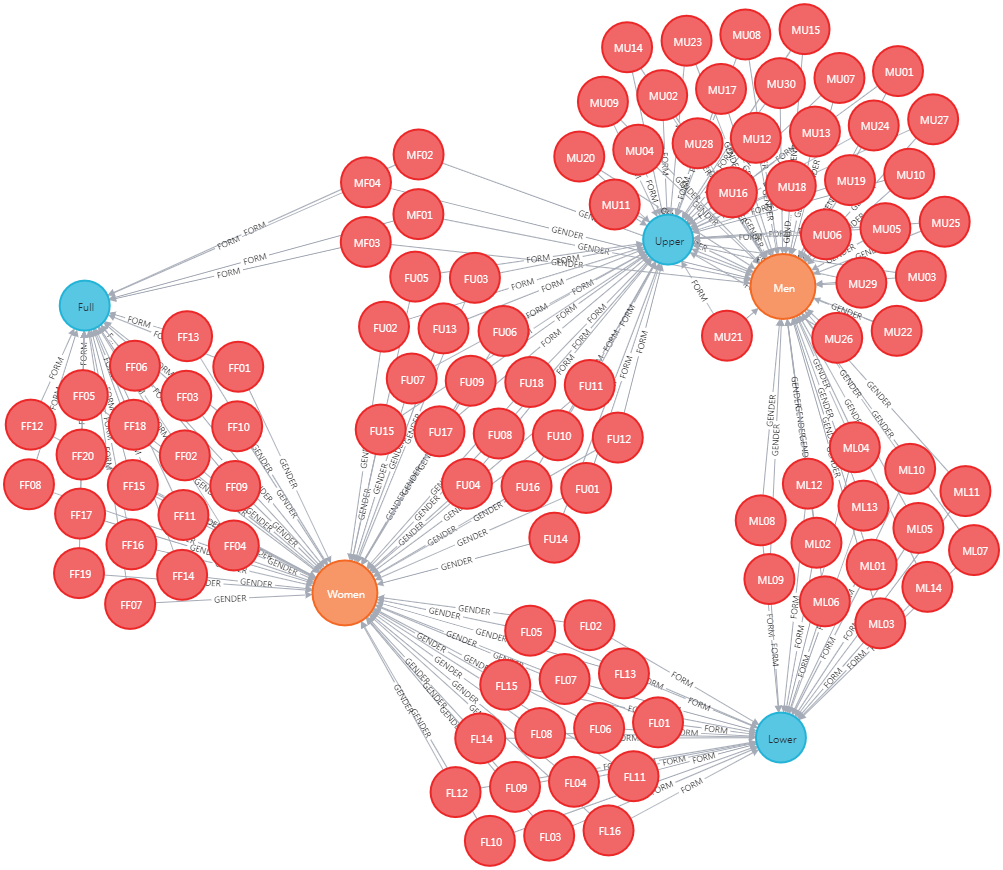

In [6]:
"""SAME and FIT relationship"""

print('Creating relationship...')
pgs = 0

for i in range(pn):
  for j in range(pn):
    code = relation_df[psn[i]][psn[j]]
    if code <= 0.0:
      pass
    elif code == 2:
      r = neo.Relationship(product_node[i], 'SAME', product_node[j])
      fashion_map.merge(r)
    else:
      r = neo.Relationship(product_node[i], 'FIT', product_node[j])
      r['score'] = round(code, 3)
      fashion_map.merge(r)
   
  # progress bar
  pgs += 1
  print('\r' + '[SAME&FIT]:[%s%s]%.2f%%' % ('█' * int(pgs*30/pn),
     '  ' * (30-int(pgs*30/pn)),
     float(pgs/pn*100)), end='')
  
print('\nDone.')

Creating relationship...
[SAME&FIT]:[██████████████████████████████]100.00%
Done.


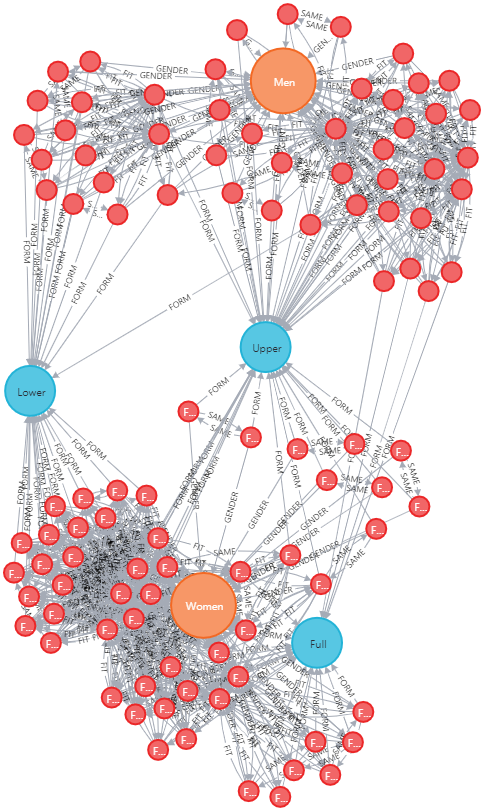

In [7]:
"""Query function"""
# node matching
total_nodes = neo.NodeMatch(fashion_map)
Gender_nodes = neo.NodeMatch(fashion_map, labels=frozenset(['Gender']))
Form_nodes = neo.NodeMatch(fashion_map, labels=frozenset(['Form']))
Product_nodes = neo.NodeMatch(fashion_map, labels=frozenset(['Product']))

print('Total:', len(total_nodes))
print('Gender:', len(Gender_nodes))
print('Form:', len(Form_nodes))
print('Product:', len(Product_nodes))

Total: 107
Gender: 2
Form: 3
Product: 102


In [8]:
Product_nodes.first()

Node('Product', description='特色是線條俐落的緊身長褲。使用彈性極佳的素材，實現舒適的穿著感。高腰設計，具修飾腿長的效果。可搭配多種造型的實用款式。深藍', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/320999/item/65_320999.jpg', name='高腰緊身牛仔褲', sn='FL09')

In [9]:
list(Product_nodes.limit(10))

[Node('Product', description='特色是線條俐落的緊身長褲。使用彈性極佳的素材，實現舒適的穿著感。高腰設計，具修飾腿長的效果。可搭配多種造型的實用款式。深藍', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/320999/item/65_320999.jpg', name='高腰緊身牛仔褲', sn='FL09'),
 Node('Product', description='特色是線條俐落的緊身長褲。使用彈性極佳的素材，實現舒適的穿著感。高腰設計，具修飾腿長的效果。可搭配多種造型的實用款式。海軍藍', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/320999/item/69_320999.jpg', name='高腰緊身牛仔褲', sn='FL10'),
 Node('Product', description='女裝附腰帶寬褲(格紋) 灰色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328295/item/03_328295.jpg', name='附腰帶寬褲', sn='FL11'),
 Node('Product', description='女裝附腰帶寬褲(格紋) 棕色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328295/item/35_328295.jpg', name='附腰帶寬褲', sn='FL12'),
 Node('Product', description='窄管褲剪裁的輕便褲。採用外觀乾淨的設計，外出穿也方便。使用觸感柔軟舒適的平織素材，讓穿著感更舒適。腰部和腳踝有高密度羅紋，更合身。米白色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/325118/item/30_325118.jpg', name='休閒輕便褲', sn='FL13'),
 Node('Product', description='窄管褲剪裁的輕便褲。採用外觀乾淨的設計，外出穿也方便。使用觸感柔軟舒適的平

In [10]:
list(Product_nodes.where('_.sn =~ "MF.*"'))

[Node('Product', description='寬版格紋大衣 男裝，具時尚感的寬版大衣。附便利内口袋，實用性佳。可搭配正式造型，用途廣泛。 灰色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328943/item/36_328943.jpg', name='寬版格紋大衣', sn='MF01'),
 Node('Product', description='寬版格紋大衣 男裝，具時尚感的寬版大衣。附便利内口袋，實用性佳。可搭配正式造型，用途廣泛。 棕色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328943/item/03_328943.jpg', name='寬版格紋大衣', sn='MF02'),
 Node('Product', description='寬版格紋大衣 男裝，具時尚感的寬版大衣。附便利内口袋，實用性佳。可搭配正式造型，用途廣泛。 深灰色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328943/item/08_328943.jpg', name='寬版格紋大衣', sn='MF03'),
 Node('Product', description='羊毛混紡切斯特大衣 男裝羊毛混紡切斯特大衣CL 海軍藍', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/326109/item/69_326109.jpg', name='羊毛混紡切斯特大衣', sn='MF04')]

In [11]:
# relation matching
total_relations = neo.RelationshipMatch(fashion_map)
GEMDER_relations = neo.RelationshipMatch(fashion_map, r_type='GENDER')
FORM_relations = neo.RelationshipMatch(fashion_map, r_type='FORM')
SAME_relations = neo.RelationshipMatch(fashion_map, r_type='SAME')
FIT_relations = neo.RelationshipMatch(fashion_map, r_type='FIT')

print('Total:', len(total_relations))
print('GENDER:', len(GEMDER_relations))
print('FORM:', len(FORM_relations))
print('SAME', len(SAME_relations))
print('FIT:', len(FIT_relations))

Total: 2674
GENDER: 102
FORM: 102
SAME 86
FIT: 2384


In [12]:
# inspect SAME and FIT
same = 0
fit = 0

for i in range(pn):
  for j in range(pn):
    code = relation_df[psn[i]][psn[j]]
    if code <= 0.0:
      pass
    elif code == 2:
      same += 1
    else:
      fit += 1

print('SAME:', same)
print('FIT:', fit)

SAME: 86
FIT: 2384


In [13]:
GEMDER_ten = list(GEMDER_relations.limit(10))

for r in list(GEMDER_ten):
  print(r)

(高腰緊身牛仔褲)-[:GENDER {}]->(_145)
(高腰緊身牛仔褲)-[:GENDER {}]->(_145)
(附腰帶寬褲)-[:GENDER {}]->(_145)
(附腰帶寬褲)-[:GENDER {}]->(_145)
(休閒輕便褲)-[:GENDER {}]->(_145)
(休閒輕便褲)-[:GENDER {}]->(_145)
(絨面合身中長裙)-[:GENDER {}]->(_145)
(絨面合身中長裙)-[:GENDER {}]->(_145)
(寬版高領針織長上衣)-[:GENDER {}]->(_145)
(寬版高領針織長上衣)-[:GENDER {}]->(_145)


In [14]:
FIT_score_filter = FIT_relations.where('_.score >= 0.945')

for r in list(FIT_score_filter):
  print(r)

(泡芙袖針織POLO衫)-[:FIT {score: 0.95}]->(男裝府綢襯衫)
(學院風針織衫)-[:FIT {score: 0.945}]->(鋪棉燈芯絨寬版外套)
(窄管條紋褲)-[:FIT {score: 0.949}]->(經典款風衣)
(經典款風衣)-[:FIT {score: 0.949}]->(窄管條紋褲)
(鋪棉燈芯絨寬版外套)-[:FIT {score: 0.945}]->(學院風針織衫)
(男裝府綢襯衫)-[:FIT {score: 0.95}]->(泡芙袖針織POLO衫)


In [15]:
"""
Recommender Algorithm
(Prime product) -> (First-degree relation) -> (Second-degree relation)
[SAME]: pick randomly
[FIT]: pick randomly base on weight
"""
# pick a node randomly as the prime
rand_int = random.randint(0, len(Product_nodes))
product_prime = list(Product_nodes)[rand_int]

print('Serial number:', product_prime['sn'])
print('主推薦:', product_prime['name'])

Serial number: FF10
主推薦: 格紋吊帶連身裙


In [16]:
# SAME relation
prime_SAME = neo.RelationshipMatch(fashion_map, nodes=[product_prime], r_type='SAME')

print('Quantity:', len(prime_SAME))

for r in range(len(prime_SAME)):
  print(list(prime_SAME)[r])

list(prime_SAME)[0].end_node

Quantity: 1
(格紋吊帶連身裙)-[:SAME {}]->(格紋吊帶連身裙)


Node('Product', description='女孩系列-格紋吊帶連身裙JR+E(AND24LOVELY) 復古風的圖案設計很搶眼的連身裙。特色是「AND24LOVELY」的LOGO刺繡，增添休閒感。 海軍藍', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/328794/item/69_328794.jpg', name='格紋吊帶連身裙', sn='FF09')

In [17]:
# first-degree FIT relation
prime_FIT = neo.RelationshipMatch(fashion_map, nodes=[product_prime], r_type='FIT')

# rank by score
prime_FIT_top3 = list(prime_FIT.order_by('_.score DESC'))[:3]

print('Quantity:', len(prime_FIT))
print('Top 3 fit:')
for r in prime_FIT_top3:
  print(r)

Quantity: 22
Top 3 fit:
(格紋吊帶連身裙)-[:FIT {score: 0.722}]->(高腰緊身牛仔褲)
(格紋吊帶連身裙)-[:FIT {score: 0.696}]->(連身褲)
(格紋吊帶連身裙)-[:FIT {score: 0.682}]->(水洗加工牛仔緊身褲)


In [18]:
prime_FIT_top1 = list(prime_FIT_top3)[0]

print('Top 1 fit:', prime_FIT_top1)
prime_FIT_top1.end_node

Top 1 fit: (格紋吊帶連身裙)-[:FIT {score: 0.722}]->(高腰緊身牛仔褲)


Node('Product', description='線條俐落的緊身牛仔褲。採用穿著感舒適的彈性素材。高腰設計，具修飾腿長效果，十分貼心。可搭配各式各樣造型的百搭款。黑色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/325252/item/09_325252.jpg', name='高腰緊身牛仔褲', sn='FL07')

In [20]:
# second-degree FIT relation
product_second = prime_FIT_top1.end_node
second_FIT = neo.RelationshipMatch(fashion_map, nodes=[product_second], r_type='FIT')
third_FIT = list(second_FIT.order_by('_.score DESC'))[1]

print(third_FIT)
third_FIT.end_node

(高腰緊身牛仔褲)-[:FIT {score: 0.847}]->(寬版連身褲)


Node('Product', description='圍裙樣式的連身褲。一穿上就很有時尚感，不會讓夏季造型太單調。柔軟的喬其紗素材具有舒適穿著感。必備1件的實用款。 米色', image_url='https://im.uniqlo.com/images/tw/gu/pc/goods/326203/item/32_326203.jpg', name='寬版連身褲', sn='FF06')

In [22]:
print('主推薦:', product_prime['name'])

if len(prime_SAME) != 0:
  print('同款推薦:', list(prime_SAME)[0].end_node['name'])
else:
  print('同款推薦: 無')

print('一階穿搭推薦:', prime_FIT_top1.end_node['name'])
print('二階穿搭推薦:', third_FIT.end_node['name'])

主推薦: 格紋吊帶連身裙
同款推薦: 格紋吊帶連身裙
一階穿搭推薦: 高腰緊身牛仔褲
二階穿搭推薦: 寬版連身褲


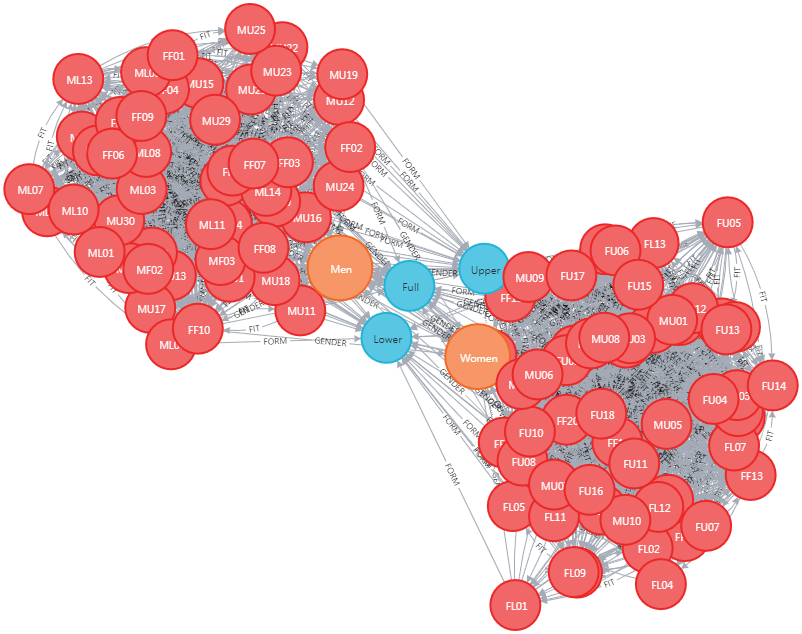